In [15]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('../quality_sql.json') as f: 
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

#establish a database connection and cursor
try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [16]:
#get distributions of values for fields
#code default pulls unfiltered data, filters can be applied using named arguments.
def field_dist_geo(field=None, table=None, geo_level=None, prop_type="'1','2','3'", loan_purp="'1', '2','3'", loan_type="'1','2','3','4'", lien="'1','2','3'", occupancy="'1','2','3'"):
    """generates a sql statement used to pull values and associated counts for the listed variable subject to listed filters"""
    
    
    if field is None: #stop SQL pull if no field is supplied
        raise ValueError("field is required")
        
    if geo_level == 'MSA':
        geo_sql = 'msa,'
    elif geo_level == 'state':
        geo_sql = 'state,'
    elif geo_level == 'county':
        geo_sql = 'CONCAT(state,county),'
    elif geo_level == 'tract':
        geo_sql = 'CONCAT(state,county,tract),'
    else:
        geo_sql = ''
    
    dist_sql = """SELECT DISTINCT year, {geo_sql} {field}, COUNT({field}) 
    FROM {table} """.format(table=table, field=field, geo_sql=geo_sql) 
    
    #removing the bulk of quesitonable data in exploration by removing HUD
    where_sql = """WHERE agency != '7' AND property_type IN ({prop_type}) AND loan_purpose IN ({loan_purp}) 
    AND loan_type IN ({loan_type}) AND lien IN ({lien}) AND occupancy IN ({occupancy}) """.format(prop_type=prop_type, loan_purp=loan_purp, loan_type=loan_type, lien=lien, occupancy=occupancy)

    group_sql = """GROUP BY year, {geo_group} {field}""".format(field=field, geo_group=geo_sql)
    order_sql = """ ORDER by {field} ASC """.format(field=field)
    return_sql = dist_sql + where_sql + group_sql + order_sql
    print(return_sql)
    return return_sql

In [17]:
def get_field_dist(year=None, field=None, geo_level=None, prop_type="'1','2','3'", loan_purp="'1', '2','3'", loan_type="'1','2','3','4'", lien="'1','2','3'", occupancy="'1','2','3'"):
    """executes SQL to get distributions of data by selected geography for the stated field for multiple years of hmda"""
    first = True
    while year > 2003:
        table = 'hmdalar' + str(year)
        print(table)
        cur.execute(field_dist_geo(table=table, field=field, geo_level=geo_level, prop_type=prop_type, loan_purp=loan_purp, loan_type=loan_type, lien=lien, occupancy=occupancy))        
        data_df = pd.DataFrame(cur.fetchall())

        col_names = [desc[0] for desc in cur.description]
        if len(data_df.columns) == len(col_names):
            print('setting column names')
            data_df.columns = col_names

        if first == True and len(data_df.columns) > 0:
            dist_df = data_df.copy()
            first = False

        elif first == False and len(data_df.columns) > 0:
            print('merging dataframes')
            dist_df=dist_df.merge(data_df, how='outer')

        else:
            print('no data returned from query')

        print(dist_df.tail())
        path = '../data/'
        if not os.path.exists(path):
            os.makedirs(path)

        year -= 1
    dist_df.to_csv(path + '{field}_dist_{geo_level}{prop_type}.csv'.format(field=field, geo_level=geo_level, prop_type=prop_type),index=False)
    print('writing df to {path}'.format(path=path))

In [18]:
#field=None, table=None, geo_level=None, prop_type=None, loan_purp=None, loan_type=None
kwargs={'year':2014,
       'field':'amount'}
#field_dist_geo(table='hmdalar2014', field='amount')
get_field_dist(**kwargs)

hmdalar2014
SELECT DISTINCT year,  amount, COUNT(amount) 
    FROM hmdalar2014 WHERE agency != '7' AND property_type IN ('1','2','3') AND loan_purpose IN ('1', '2','3') 
    AND loan_type IN ('1','2','3','4') AND lien IN ('1','2','3') AND occupancy IN ('1','2','3') GROUP BY year,  amount ORDER by amount ASC 
setting column names
      year amount  count
6339  2014  95550      1
6340  2014  97000      1
6341  2014  98000      1
6342  2014  99161      1
6343  2014  99999     59
hmdalar2013
SELECT DISTINCT year,  amount, COUNT(amount) 
    FROM hmdalar2013 WHERE agency != '7' AND property_type IN ('1','2','3') AND loan_purpose IN ('1', '2','3') 
    AND loan_type IN ('1','2','3','4') AND lien IN ('1','2','3') AND occupancy IN ('1','2','3') GROUP BY year,  amount ORDER by amount ASC 
setting column names
merging dataframes
       year amount  count
12667  2013  92160    1.0
12668  2013  92500    1.0
12669  2013  95000    3.0
12670  2013  99000    1.0
12671  2013  99999   50.0
hmdalar2012
S

In [29]:
#Histogram viz of field frequency 
dist_df = pd.read_csv('../data/amount_dist_all.csv')
dist_df.sort_values('amount', inplace=True)
dist_df.head()


year  amount    count
0      2014       1  11791.0
18489  2011       1  10046.0
23982  2010       1  10304.0
28883  2009       1   9646.0
6344   2013       1  11287.0

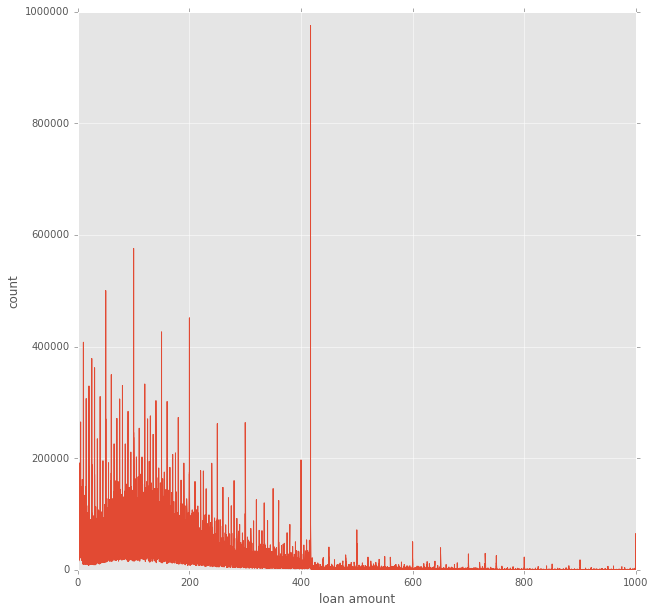

In [32]:
fig = plt.figure(figsize=(10,10))
y = dist_df['count']
x = dist_df.amount
ax=plt.subplot()
ax.set_xlim(0,1000)
plt.xlabel('loan amount')
plt.ylabel('count')
plt.plot(x,y)
plt.show()